### Visualize Factor Correlations

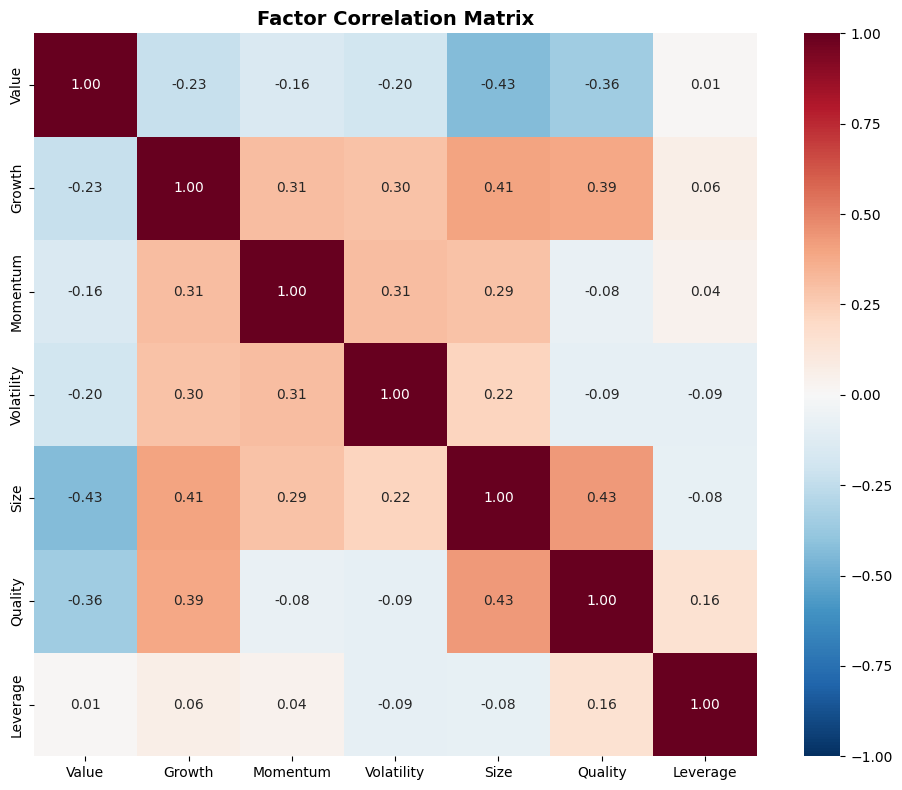


Highly correlated factors:
Value vs Size: -0.43
Growth vs Size: 0.41
Size vs Quality: 0.43


In [23]:
# Plot correlation between style factors
style_factors = ['Value', 'Growth', 'Momentum', 'Volatility', 'Size', 'Quality', 'Leverage']
factor_corr = factor_exposures[style_factors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(factor_corr, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True)
plt.title('Factor Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHighly correlated factors:")
for i in range(len(factor_corr.columns)):
    for j in range(i+1, len(factor_corr.columns)):
        corr = factor_corr.iloc[i, j]
        if abs(corr) > 0.4:
            print(f"{factor_corr.columns[i]} vs {factor_corr.columns[j]}: {corr:.2f}")

### Estimate Factor Returns (Cross-Sectional Regression)

In [24]:
# Estimate factor returns using cross-sectional regression
# For each date: returns = factor_exposures * factor_returns + residual

print("Estimating factor returns...")

# Align data
common_stocks = returns.columns.intersection(factor_exposures.index)
returns_aligned = returns[common_stocks]
exposures_aligned = factor_exposures.loc[common_stocks]

# Storage for results
factor_returns_list = []

# Loop through each date
for date in returns_aligned.index[:]:  # Use all dates
    # Get returns for this date
    r_t = returns_aligned.loc[date].dropna()
    
    # Get exposures for stocks with returns
    valid_stocks = r_t.index
    X_t = exposures_aligned.loc[valid_stocks]
    
    # Skip if insufficient data
    if len(r_t) < 30:
        continue
    
    # Run regression: returns = X * factor_returns
    model = LinearRegression(fit_intercept=False)
    model.fit(X_t, r_t)
    
    # Store factor returns
    factor_returns_list.append({
        'date': date,
        **dict(zip(X_t.columns, model.coef_))
    })

# Convert to DataFrame
factor_returns = pd.DataFrame(factor_returns_list).set_index('date')

print(f"\nEstimated factor returns for {len(factor_returns)} periods")
print(f"Factor returns shape: {factor_returns.shape}")
print("\nFirst few rows:")
print(factor_returns.head())

Estimating factor returns...

Estimated factor returns for 500 periods
Factor returns shape: (500, 18)

First few rows:
               Value    Growth  Momentum  Volatility      Size   Quality  \
date                                                                       
2023-12-21  0.000376  0.000572  0.000773    0.003512 -0.000149 -0.001051   
2023-12-22 -0.000009  0.002765 -0.000202   -0.003986  0.002040 -0.005588   
2023-12-26 -0.001141 -0.002414  0.002770    0.003726 -0.002106  0.000365   
2023-12-27 -0.000832  0.001942 -0.000246    0.000850  0.000320 -0.001884   
2023-12-28  0.000469  0.000813  0.002023   -0.001850 -0.003046  0.001654   

            Leverage  Sector_Communication Services  \
date                                                  
2023-12-21  0.000173                       0.007585   
2023-12-22  0.001313                      -0.000853   
2023-12-26 -0.000185                       0.004816   
2023-12-27  0.000392                      -0.000869   
2023-12-28 -0.000

### Analyze Factor Returns

Annualized Factor Returns (%):
Momentum      10.536339
Growth         7.407192
Volatility     5.378090
Size           4.417593
Leverage       0.679717
Quality       -2.215595
Value         -2.972679
dtype: float64


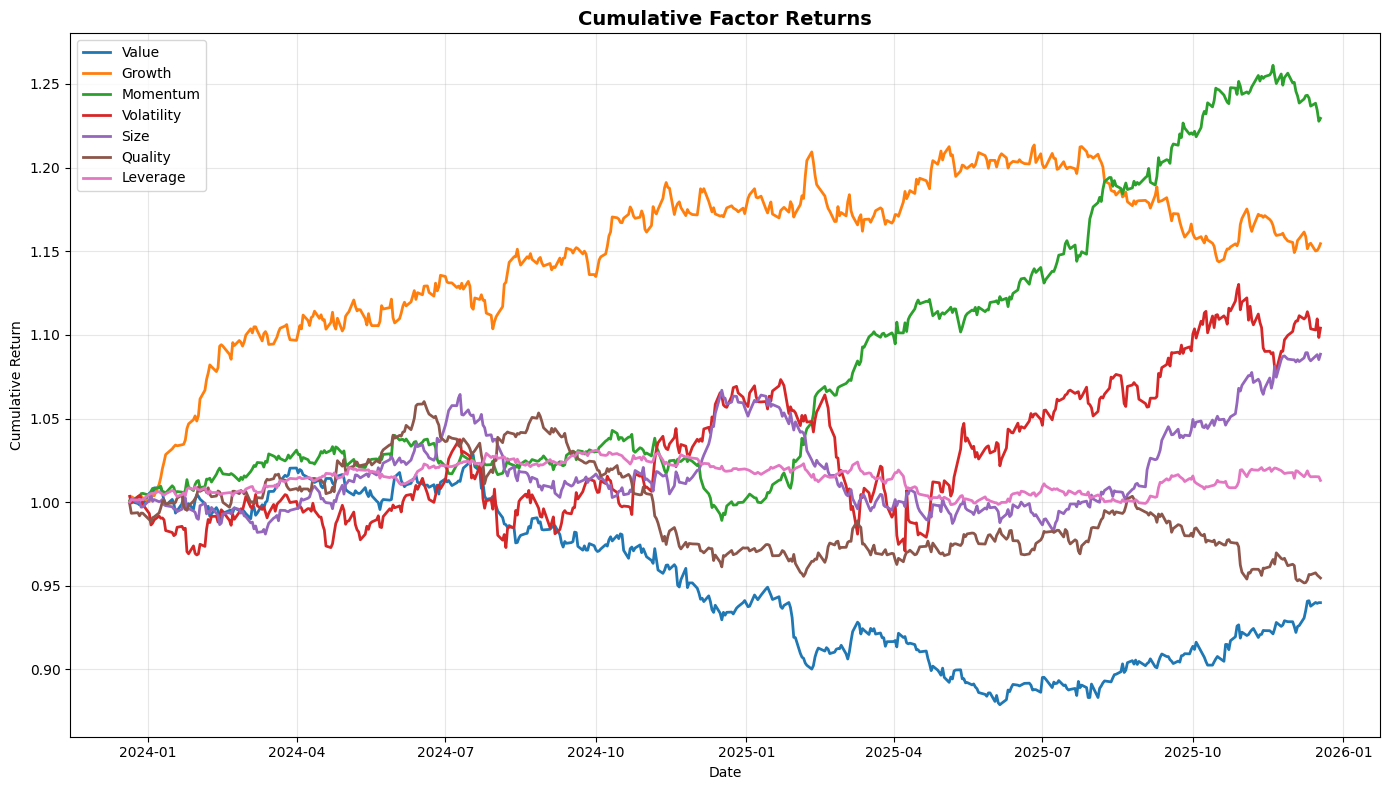

In [46]:
# Calculate annualized factor returns
annualized_returns = factor_returns[style_factors].mean() * 252 * 100

print("Annualized Factor Returns (%):")
print(annualized_returns.sort_values(ascending=False))

# Plot cumulative factor returns
cumulative_returns = (1 + factor_returns[style_factors]).cumprod()

plt.figure(figsize=(14, 8))
for factor in style_factors:
    plt.plot(cumulative_returns.index, cumulative_returns[factor], label=factor, linewidth=2)

plt.title('Cumulative Factor Returns', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Calculate Factor Covariance Matrix (EWMA)

In [26]:
# Calculate exponentially weighted covariance matrix
print("Calculating factor covariance matrix...")

# Parameters
half_life = 90  # 90 days
lambda_param = np.exp(-np.log(2) / half_life)

# Calculate weights
n = len(factor_returns)
weights = np.array([lambda_param ** i for i in range(n)])[::-1]
weights = weights / weights.sum()

print(f"Using {n} periods with half-life of {half_life} days")
print(f"Most recent weight: {weights[-1]:.4f}")
print(f"Oldest weight: {weights[0]:.4f}")

# Center the data (demean)
factor_returns_mean = factor_returns.mean()
centered = factor_returns - factor_returns_mean

print(f"\nCentered data shape: {centered.shape}")

# Convert to numpy arrays for calculation
centered_values = centered.values
weights_diag = np.diag(weights)

# Weighted covariance calculation: C = X^T @ W @ X
# where X is the centered data (T x N) and W is diagonal weight matrix (T x T)
factor_covariance_values = centered_values.T @ weights_diag @ centered_values * 252  # Annualized

# Convert back to DataFrame with proper labels
factor_covariance = pd.DataFrame(
    factor_covariance_values,
    index=factor_returns.columns,
    columns=factor_returns.columns
)

print(f"\nFactor covariance matrix shape: {factor_covariance.shape}")

# Calculate factor volatilities (annualized %)
factor_vols = np.sqrt(np.diag(factor_covariance)) * 100

print("\nAnnualized Factor Volatilities (%):")
vol_series = pd.Series(factor_vols, index=factor_covariance.index)

# Show style factors if they exist
if 'style_factors' in locals():
    available_style = [f for f in style_factors if f in vol_series.index]
    if available_style:
        print(vol_series[available_style].sort_values(ascending=False))
    else:
        print(vol_series.sort_values(ascending=False).head(10))
else:
    print(vol_series.sort_values(ascending=False).head(10))

print("\nCovariance matrix diagonal (variance):")
print(f"Min: {np.diag(factor_covariance).min():.4f}")
print(f"Max: {np.diag(factor_covariance).max():.4f}")
print(f"Mean: {np.diag(factor_covariance).mean():.4f}")

Calculating factor covariance matrix...
Using 500 periods with half-life of 90 days
Most recent weight: 0.0078
Oldest weight: 0.0002

Centered data shape: (500, 18)

Factor covariance matrix shape: (18, 18)

Annualized Factor Volatilities (%):
Volatility    8.995391
Size          5.428035
Value         5.404982
Momentum      5.361568
Growth        5.296350
Quality       4.720908
Leverage      2.578583
dtype: float64

Covariance matrix diagonal (variance):
Min: 0.0007
Max: 0.0582
Mean: 0.0217


### Visualize Factor Covariance

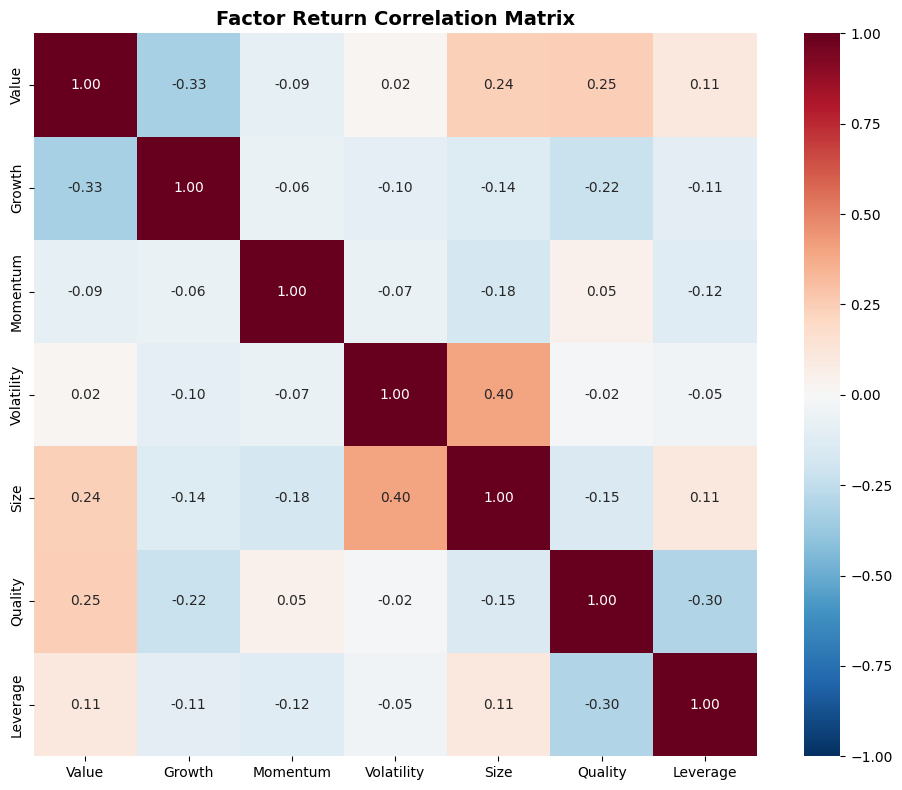

In [27]:
# Convert covariance to correlation
factor_std = np.sqrt(np.diag(factor_covariance))
factor_correlation = factor_covariance / np.outer(factor_std, factor_std)

# Plot style factor correlations
style_corr = factor_correlation.loc[style_factors, style_factors]

plt.figure(figsize=(10, 8))
sns.heatmap(style_corr, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True)
plt.title('Factor Return Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Calculate Specific Risk

In [28]:
# Calculate specific (idiosyncratic) risk for each stock
print("Calculating specific risk...")

# Calculate residuals (specific returns)
specific_returns = pd.DataFrame(index=returns_aligned.index, columns=common_stocks)

for date in factor_returns.index:
    if date not in returns_aligned.index:
        continue
    
    r_t = returns_aligned.loc[date]
    f_t = factor_returns.loc[date]
    
    # Predicted returns from factor model
    predicted = exposures_aligned @ f_t
    
    # Specific returns = actual - predicted
    specific_returns.loc[date] = r_t - predicted

# Calculate EWMA specific variance
print("Calculating EWMA specific variance...")

half_life_specific = 60
lambda_specific = np.exp(-np.log(2) / half_life_specific)

specific_variance = {}

for stock in common_stocks:
    residuals = specific_returns[stock].dropna()
    
    if len(residuals) < 20:
        specific_variance[stock] = residuals.var() * 252
        continue
    
    # EWMA variance
    n_resid = len(residuals)
    weights_sp = np.array([lambda_specific ** i for i in range(n_resid)])[::-1]
    weights_sp = weights_sp / weights_sp.sum()
    
    centered_resid = residuals - residuals.mean()
    var = (weights_sp * centered_resid ** 2).sum() * 252  # Annualized
    specific_variance[stock] = var

specific_risk = pd.Series(specific_variance)

print(f"\nSpecific risk calculated for {len(specific_risk)} stocks")
print(f"\nSpecific Risk Statistics:")
print(f"Mean specific volatility: {np.sqrt(specific_risk.mean()) * 100:.2f}%")
print(f"Median specific volatility: {np.sqrt(specific_risk.median()) * 100:.2f}%")
print(f"Min/Max: {np.sqrt(specific_risk.min()) * 100:.2f}% / {np.sqrt(specific_risk.max()) * 100:.2f}%")

Calculating specific risk...
Calculating EWMA specific variance...

Specific risk calculated for 91 stocks

Specific Risk Statistics:
Mean specific volatility: 21.05%
Median specific volatility: 19.41%
Min/Max: 0.00% / 53.58%
